# Extracting low water line boundaries for Queensland Ramsar sites <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 


## Description
Project in collaboration with Queensland Department of Environment and Science
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [77]:
import sys
import datacube
import numpy as np
import geopandas as gpd
from datacube.utils import geometry
import xarray as xr
from skimage.morphology import remove_small_holes, binary_opening

sys.path.append('../Scripts')
from dea_plotting import map_shapefile
from dea_spatialtools import subpixel_contours


def keep_longest(geom):
    """
    Takes a MultiLineString, and returns only the longest LineString
    in that feature.
    """

    # Break MultiLineString into individual lines
    geoms = geom.explode()
    
    # Identify longest line
    longest_geom = geoms[geoms.length == max(geoms.length)][0]
    
    return longest_geom

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [16]:
dc = datacube.Datacube(app='DES_Ramsar_boundaries')

### Analysis parameters

* `boundary_shp`: Path to the shapefile containing boundaries for the Ramsar site


In [17]:
boundary_shp = 'extent.geojson'

## Load data
### Load extent

In [18]:
boundary_gdf = gpd.read_file(boundary_shp).to_crs('EPSG:3577')
geom = geometry.Geometry(geom=boundary_gdf.iloc[0].geometry, 
                         crs=boundary_gdf.crs)

map_shapefile(boundary_gdf, attribute='id')

Label(value='')

Map(center=[-19.340254764178255, 147.24586987951295], controls=(ZoomControl(options=['position', 'zoom_in_text…

### Load intertidal data

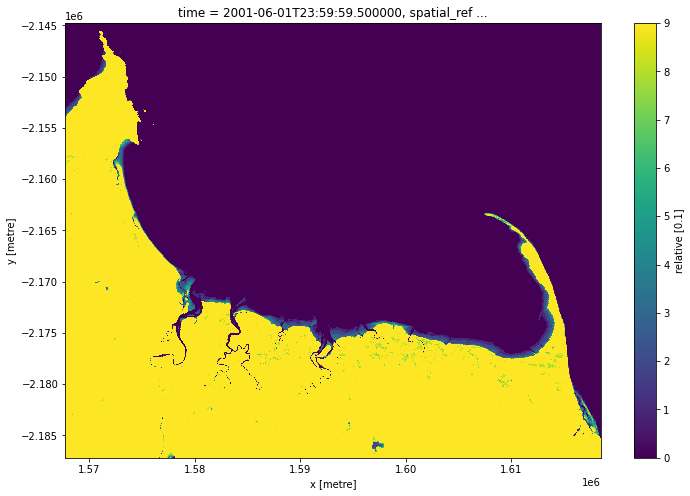

In [19]:
# Load data
item = dc.load(product='item_v2',
               geopolygon=geom).relative

# Set -6666 to NaN
item = item.where(item != -6666)

# Plot
item.plot(size=8)

## Analysis

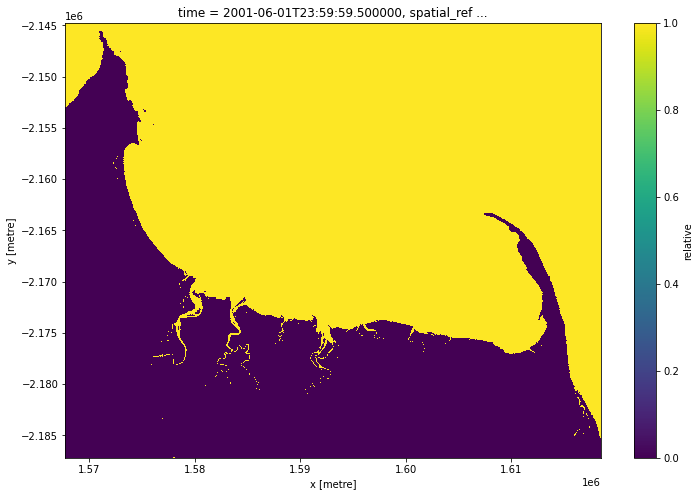

In [96]:
interval = 1

# Convert to two classes around specified interval
item_thresh = item < interval
item_thresh.plot(size=8)

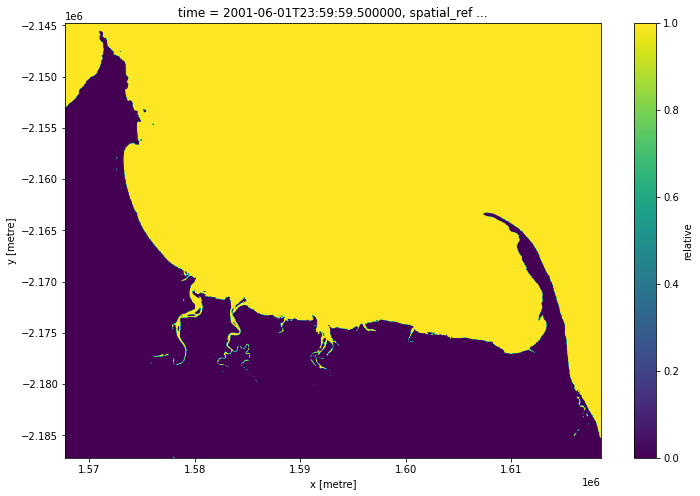

In [100]:
# Remove small islands and lakes unconnected from mainland or ocean
# no_islands = xr.apply_ufunc(remove_small_holes, item_thresh, 1000)
# no_lakes = xr.apply_ufunc(remove_small_holes, ~no_islands, 1000)

# Smooth edges
item_cleaned = xr.apply_ufunc(binary_opening, item_thresh)  #no_lakes)
item_cleaned = xr.apply_ufunc(gaussian, item_cleaned)
item_cleaned.plot(size=8)

## Extract coastline

In [101]:
# Extract contour along 0 and 1.0 boundary (i.e. 0.5)
item_coastline = subpixel_contours(item_cleaned, 0.5, 
                                   crs='EPSG:3577')

# Remove any small disconnected lines in the data
item_coastline['geometry'] = keep_longest(geom=item_coastline.geometry)

# Export to file
suffix = (interval - 1) * 10
item_coastline.crs = item.geobox.crs
item_coastline.geometry.to_crs('EPSG:4326').to_file(f'tidal_coastline_{suffix}_perc.geojson', driver='GeoJSON')

Operating in single z-value, multiple arrays mode


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)